In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [3]:
def dicky_fuller(df):
    i = 0
    dftest = adfuller(np.diff(df,i), autolag='AIC')
    test_stat = dftest[0]
    critical_val_5 = dftest[4]['5%']
    while test_stat > critical_val_5:
        i+=1
        dftest = adfuller(np.diff(df,i), autolag='AIC')
        test_stat = dftest[0]
        critical_val_5 = dftest[4]['5%']
    return(i)

In [4]:
df_lf = pd.read_csv('../../src/data/df_lf_arima.csv', index_col='time', parse_dates=['time'])
# df_lf.head()

In [5]:
zipcodes = [37115, 37148, 37221, 37174, 37210]

shape of train and test datasets: (61,) (15,) 



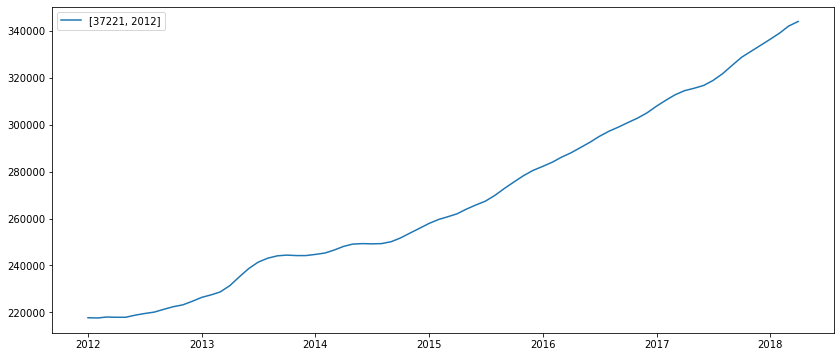

In [6]:
zip_code = zipcodes[2]    # change these params
start_year = 2012   # change these params (1996, 2010 or 2012)
eoti_percent = .8

df_zip_code = df_lf[(df_lf.RegionName== zip_code) & (df_lf.index.year >= start_year)]

eoti = round(df_zip_code.shape[0] * eoti_percent)
df_zip_code_train = df_zip_code.value[:eoti]
df_zip_code_test = df_zip_code.value[eoti:]

print("shape of train and test datasets:", df_zip_code_train.shape, df_zip_code_test.shape, '\n')

plt.subplots(figsize = (14,6))
plt.plot(df_zip_code.value, label=[zip_code,start_year])
plt.legend(loc='best');

# ARIMA

## d

In [7]:
dicky_fuller(df_zip_code_train)

# order of differencing

2

## p, q

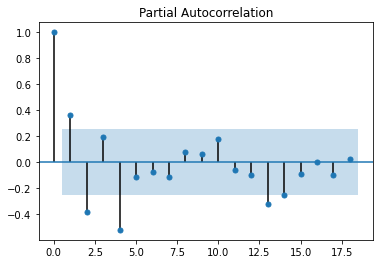

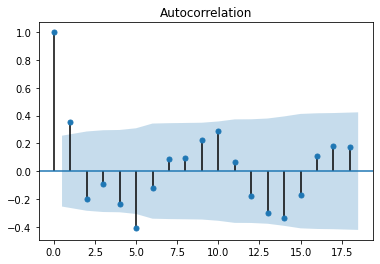

In [8]:
i = dicky_fuller(df_zip_code_train)

plot_pacf(np.diff(df_zip_code_train,i)); #ar

plot_acf(np.diff(df_zip_code_train,i)); #ma

# looks like 0,2,0 are the best params, at i = 2, 
# but they won't work with ARIMA.

In [9]:
# Let's check auto_arima for suggestions, shall we:

auto_arima(df_zip_code_train, start_p=0, d=i, start_q=0, max_p=5, max_q=5, seasonal=False, trace=True)

# Auto_arima agrees, 0,2,0 is the best. since can't do that, will choose 0,2,1

# NOTE: from the SARIMA model below, 2,2,2 gave better aic. Got better results with ARIMA too.
# But auto_arima didn't even check for it here...

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=910.026, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=911.696, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=911.712, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=908.582, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=913.903, Time=0.14 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.272 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, with_intercept=False)

## Modeling (ARIMA)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -436.931
Method:                       css-mle   S.D. of innovations            386.531
Date:                Fri, 13 Nov 2020   AIC                            885.861
Time:                        19:07:49   BIC                            898.326
Sample:                    03-01-2012   HQIC                           890.727
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             34.4254     12.589      2.735      0.006       9.751      59.100
ar.L1.D2.value     0.8122      0.152      5.332      0.000       0.514       1.111
ar.L2.D2.value    -0.1774      0.150

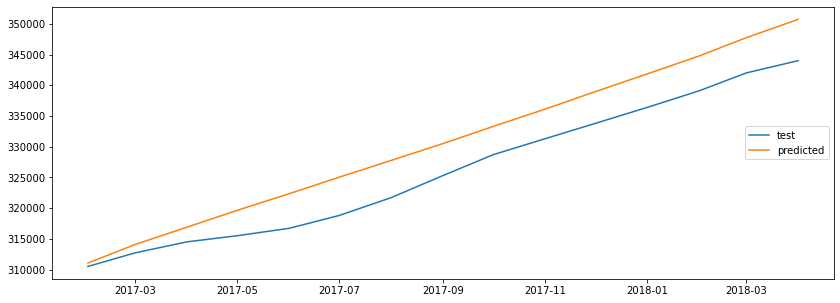

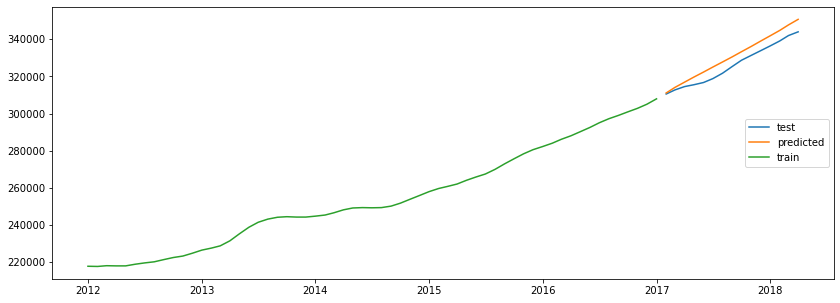

In [10]:
ar, i, ma = [2,2,2] # change these params

model = ARIMA(df_zip_code_train, (ar,i,ma), freq='MS').fit()
y_hat_model = model.predict(typ='levels')
rmse_model = np.sqrt(mean_squared_error(df_zip_code_train[i:], y_hat_model))

test_start_dt = df_zip_code_test.index[0]
test_end_dt = df_zip_code_test.index[-1]
y_hat_model_test = model.predict(start=test_start_dt, end=test_end_dt, typ='levels')
rmse_model_test = np.sqrt(mean_squared_error(df_zip_code_test, y_hat_model_test))

print(model.summary(), '\n')
print('train rmse:', rmse_model, '\n')
print('test rmse:', rmse_model_test, '\n')
print('train aic:', model.aic, '\n')

fig, ax2 = plt.subplots(figsize=(14,5))
ax2.plot(df_zip_code_test, label='test')
ax2.plot(y_hat_model_test, label='predicted')
ax2.legend(loc="right")

fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(df_zip_code_test, label='test')
ax1.plot(y_hat_model_test, label='predicted')
ax1.plot(df_zip_code_train, label='train')
ax1.legend(loc="right");

# SARIMAX

In [11]:
import itertools

i = dicky_fuller(df_zip_code_train)

p = q = range(0, 3)
pdq = list(itertools.product(p, [i], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 2, 0) x (0, 1, 0, 12)
SARIMAX: (0, 2, 0) x (0, 1, 1, 12)
SARIMAX: (0, 2, 0) x (0, 1, 2, 12)
SARIMAX: (0, 2, 0) x (1, 1, 0, 12)
SARIMAX: (0, 2, 0) x (1, 1, 1, 12)
SARIMAX: (0, 2, 0) x (1, 1, 2, 12)
SARIMAX: (0, 2, 0) x (2, 1, 0, 12)
SARIMAX: (0, 2, 0) x (2, 1, 1, 12)
SARIMAX: (0, 2, 0) x (2, 1, 2, 12)
SARIMAX: (0, 2, 1) x (0, 1, 0, 12)
SARIMAX: (0, 2, 1) x (0, 1, 1, 12)
SARIMAX: (0, 2, 1) x (0, 1, 2, 12)
SARIMAX: (0, 2, 1) x (1, 1, 0, 12)
SARIMAX: (0, 2, 1) x (1, 1, 1, 12)
SARIMAX: (0, 2, 1) x (1, 1, 2, 12)
SARIMAX: (0, 2, 1) x (2, 1, 0, 12)
SARIMAX: (0, 2, 1) x (2, 1, 1, 12)
SARIMAX: (0, 2, 1) x (2, 1, 2, 12)
SARIMAX: (0, 2, 2) x (0, 1, 0, 12)
SARIMAX: (0, 2, 2) x (0, 1, 1, 12)
SARIMAX: (0, 2, 2) x (0, 1, 2, 12)
SARIMAX: (0, 2, 2) x (1, 1, 0, 12)
SARIMAX: (0, 2, 2) x (1, 1, 1, 12)
SARIMAX: (0, 2, 2) x (1, 1, 2, 12)
SARIMAX: (0, 2, 2) x (2, 1, 0, 12)
SARIMAX: (0, 2, 2) x (2, 1, 1, 12)
SARIMAX: (0, 2, 2) x (2, 1, 2, 12)
SARIMAX: (1, 2, 0) 

In [12]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(df_zip_code_train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False, 
                         freq='MS')
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:754.4476218014883


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/U

ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:1455.3894893018135
ARIMA(0, 2, 0)x(0, 1, 2, 12) - AIC:352.67795778729896
ARIMA(0, 2, 0)x(1, 1, 0, 12) - AIC:558.487999674769


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(1, 1, 1, 12) - AIC:558.9631280223101


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(1, 1, 2, 12) - AIC:348.9066474697836
ARIMA(0, 2, 0)x(2, 1, 0, 12) - AIC:361.8579365456495
ARIMA(0, 2, 0)x(2, 1, 1, 12) - AIC:362.9001816421038


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(2, 1, 2, 12) - AIC:348.21724895180637
ARIMA(0, 2, 1)x(0, 1, 0, 12) - AIC:722.6413515832935


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(0, 1, 1, 12) - AIC:878.0587433190219
ARIMA(0, 2, 1)x(0, 1, 2, 12) - AIC:329.96872382507087
ARIMA(0, 2, 1)x(1, 1, 0, 12) - AIC:552.4709064117886


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(1, 1, 1, 12) - AIC:725.2836188955869
ARIMA(0, 2, 1)x(1, 1, 2, 12) - AIC:327.7716434545054


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(2, 1, 0, 12) - AIC:360.4368309412631


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(2, 1, 1, 12) - AIC:362.81112836303384
ARIMA(0, 2, 1)x(2, 1, 2, 12) - AIC:330.8985187775448
ARIMA(0, 2, 2)x(0, 1, 0, 12) - AIC:695.109997304606


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(0, 1, 1, 12) - AIC:1037.2154822123034
ARIMA(0, 2, 2)x(0, 1, 2, 12) - AIC:314.75491231365385


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 0, 12) - AIC:549.6063316061574


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 1, 12) - AIC:1608.5061666838835


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 2, 12) - AIC:314.0394393536986
ARIMA(0, 2, 2)x(2, 1, 0, 12) - AIC:364.4063113482651


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(2, 1, 1, 12) - AIC:366.02894369953106
ARIMA(0, 2, 2)x(2, 1, 2, 12) - AIC:319.16344995110654
ARIMA(1, 2, 0)x(0, 1, 0, 12) - AIC:745.178350768974


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(0, 1, 1, 12) - AIC:1189.3508774554498
ARIMA(1, 2, 0)x(0, 1, 2, 12) - AIC:346.0220583695575
ARIMA(1, 2, 0)x(1, 1, 0, 12) - AIC:538.0160615107973


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(1, 1, 1, 12) - AIC:544.7710024005794


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(1, 1, 2, 12) - AIC:352.97852586555524


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 0, 12) - AIC:345.3634789164638


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 1, 12) - AIC:345.8527266775737


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 2, 12) - AIC:349.19536747675613
ARIMA(1, 2, 1)x(0, 1, 0, 12) - AIC:720.9049537164269


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(0, 1, 1, 12) - AIC:1070.8803005956115
ARIMA(1, 2, 1)x(0, 1, 2, 12) - AIC:331.81375583271466
ARIMA(1, 2, 1)x(1, 1, 0, 12) - AIC:539.82632616467


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(1, 1, 1, 12) - AIC:1407.6648994554441
ARIMA(1, 2, 1)x(1, 1, 2, 12) - AIC:328.7683241028348


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 0, 12) - AIC:346.78926035144855
ARIMA(1, 2, 1)x(2, 1, 1, 12) - AIC:349.6304937361557


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 2, 12) - AIC:332.7993232574491
ARIMA(1, 2, 2)x(0, 1, 0, 12) - AIC:696.9528732556454


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1
/Users/oz/

ARIMA(1, 2, 2)x(0, 1, 1, 12) - AIC:nan
ARIMA(1, 2, 2)x(0, 1, 2, 12) - AIC:314.03979306767667


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(1, 1, 0, 12) - AIC:538.4503400514274


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(1, 1, 1, 12) - AIC:1324.42704532891


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:311.7588504610524


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(2, 1, 0, 12) - AIC:347.0563375220527


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(2, 1, 1, 12) - AIC:350.7432939695742


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(2, 1, 2, 12) - AIC:317.9730738894415
ARIMA(2, 2, 0)x(0, 1, 0, 12) - AIC:714.4911496148168
ARIMA(2, 2, 0)x(0, 1, 1, 12) - AIC:545.2592179754605


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(0, 1, 2, 12) - AIC:344.53847761593096
ARIMA(2, 2, 0)x(1, 1, 0, 12) - AIC:519.7775044992591


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(1, 1, 1, 12) - AIC:601.4097829477547


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(1, 1, 2, 12) - AIC:346.94861410404735
ARIMA(2, 2, 0)x(2, 1, 0, 12) - AIC:327.7013239825966


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(2, 1, 1, 12) - AIC:329.6467425424778


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(2, 1, 2, 12) - AIC:335.45946914355414
ARIMA(2, 2, 1)x(0, 1, 0, 12) - AIC:715.5273413083706


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(0, 1, 1, 12) - AIC:1438.9396096935886
ARIMA(2, 2, 1)x(0, 1, 2, 12) - AIC:326.0942906011742


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 0, 12) - AIC:518.3874603638282


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 1, 12) - AIC:924.878205056204


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 2, 12) - AIC:325.36967259951103


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(2, 1, 0, 12) - AIC:331.38785698168437
ARIMA(2, 2, 1)x(2, 1, 1, 12) - AIC:336.49789874046576


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(2, 1, 2, 12) - AIC:333.4414585022002
ARIMA(2, 2, 2)x(0, 1, 0, 12) - AIC:698.0760029718422


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(0, 1, 1, 12) - AIC:966.4031640267774
ARIMA(2, 2, 2)x(0, 1, 2, 12) - AIC:314.4323821467834


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 0, 12) - AIC:519.3431537445056


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 1, 12) - AIC:1420.84515191363


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 2, 12) - AIC:312.5809600577984
ARIMA(2, 2, 2)x(2, 1, 0, 12) - AIC:330.76079755760185


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(2, 1, 1, 12) - AIC:332.1480108731743
ARIMA(2, 2, 2)x(2, 1, 2, 12) - AIC:319.1498148424793


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                   61
Model:             SARIMAX(1, 2, 2)x(1, 1, 2, 12)   Log Likelihood                -148.879
Date:                            Fri, 13 Nov 2020   AIC                            311.759
Time:                                    19:09:41   BIC                            318.729
Sample:                                01-01-2012   HQIC                           313.119
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6302      0.629      1.002      0.316      -0.603       1.863
ma.L1          0.0704      0.502   

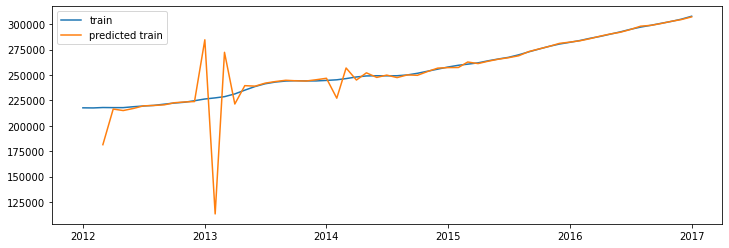

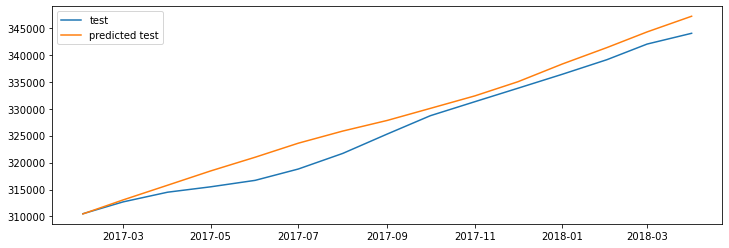

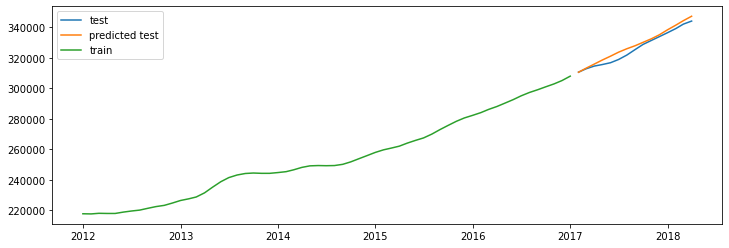

In [13]:
# ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:311.7588504610524

p,d,q = [1,2,2]
P,D,Q,s = [1,1,2,12]

sari_mod =SARIMAX(df_zip_code_train,order=(p,d,q),
                  seasonal_order=(P,D,Q,s),
                  enforce_stationarity=False,
                  enforce_invertibility=False,
                  freq='MS').fit()

y_hat_train = sari_mod.predict(typ='levels')
# second order differencing results in the first 2 predictions of a SARIMAX being invalid basically.
# in order to address that, subset from the 3rd prediction/value onwards.
# hence the [d:] below when calculating sarimax rmse train
rmse_sarimax_train = np.sqrt(mean_squared_error(df_zip_code_train[d:], y_hat_train[d:]))

y_hat_test = sari_mod.predict(start=df_zip_code_test.index[0], end=df_zip_code_test.index[-1],typ='levels')
rmse_sarimax_test = np.sqrt(mean_squared_error(df_zip_code_test,y_hat_test))

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(df_zip_code_train, label='train')
ax1.plot(y_hat_train[d:], label='predicted train')
ax1.legend(loc='best');

fig, ax2 = plt.subplots(figsize=(12,4))
ax2.plot(df_zip_code_test, label='test')
ax2.plot(y_hat_test, label='predicted test')
ax2.legend(loc='best')

fig, ax3 = plt.subplots(figsize=(12,4))
ax3.plot(df_zip_code_test, label='test')
ax3.plot(y_hat_test, label='predicted test')
ax3.plot(df_zip_code_train, label='train')
ax3.legend(loc='best')

print(sari_mod.summary(), '\n')

print('(ARIMA) train RMSE:   ', rmse_model,)
print('(SARIMAX) train RMSE: ', rmse_sarimax_train,'\n')

print('(ARIMA) test RMSE:   ', rmse_model_test)
print('(SARIMAX) test RMSE: ', rmse_sarimax_test,'\n')

print('(ARIMA) train AIC:   ', model.aic)
print('(SARIMAX) train AIC: ', sari_mod.aic, '\n')

# Forecast

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


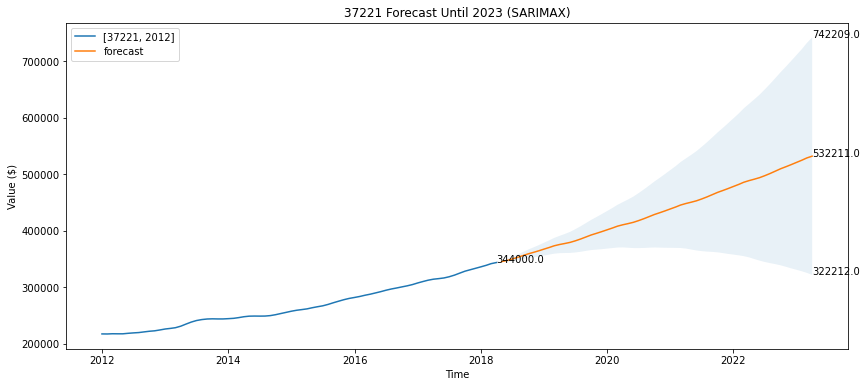

In [14]:
n = 60

sari_mod =SARIMAX(df_zip_code.value, order=(p,d,q),
                  seasonal_order=(P,D,Q,s),
                  enforce_stationarity=False,
                  enforce_invertibility=False,
                  freq='MS').fit()

forecast = sari_mod.forecast(steps = n)

get_forecast = sari_mod.get_forecast(steps=n).summary_frame()

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df_zip_code.value, label=[zip_code,start_year])
ax.plot(forecast, label='forecast')
ax.fill_between(get_forecast.index, get_forecast.mean_ci_lower, get_forecast.mean_ci_upper, alpha=0.1)

ax.annotate(round(df_zip_code.value[-1],0),
            (df_zip_code.index[-1], df_zip_code.value[-1]))
ax.annotate(round(get_forecast.mean_ci_upper[-1],0),
            (get_forecast.index[-1], get_forecast.mean_ci_upper[-1]))
ax.annotate(round(get_forecast['mean'][-1],0),
            (get_forecast.index[-1], get_forecast['mean'][-1]))
ax.annotate(round(get_forecast.mean_ci_lower[-1],0),
            (get_forecast.index[-1], get_forecast.mean_ci_lower[-1]))

ax.set_title(f'{zip_code} Forecast Until 2023 (SARIMAX)')
ax.set_ylabel('Value ($)')
ax.set_xlabel('Time')

ax.legend(loc='upper left');

plt.savefig(f'{zip_code}_forecast_sarimax.png');

In [15]:
b = df_zip_code.value[-1]
e = forecast.values[-1]

percent_diff_37115 = (e-b)/b
print('difference in percentage: ', percent_diff_37115*100)

difference in percentage:  54.712373045514894


# Conclusion: ARIMA vs Prophet (hunters model)

We're choosing Hunters model bc it has a lower RMSE, & MAPE (calculated below), for our test vs predicted data.

In [16]:
MAPE = round(np.mean(np.abs(df_zip_code_test - y_hat_test)/ df_zip_code_test) * 100, 2) #mean absolute percentage error
MAPE

0.69

In [17]:
zip_code

37221